# Load Data

In [1]:
import numpy as np
import torch

In [2]:
# import sys, importlib.util, pathlib
#
# PROJECT_ROOT = pathlib.Path("/home/may33/projects/ml_portfolio").resolve()
# if PROJECT_ROOT not in sys.path:
#     sys.path.insert(0, str(PROJECT_ROOT))
#
#
# print("Top-level path  :", sys.path[0])
# print("robotics found  :", importlib.util.find_spec("robotics") is not None)
# print("BeautifulSoup   :", importlib.util.find_spec("bs4"))
# print("Notebook dir    :", pathlib.Path().resolve())

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import h5py

data_path = "../robomimic/datasets/tool_hang/ph/image_agent.hdf5"

f = h5py.File(data_path, "r")

data = f["data"]

In [22]:
demo = data["demo_2"]

obs = demo["obs"]["agentview_image_normalized"][0]

In [5]:
# from robotics.model_src.dataset import normalize_data
# from tqdm import tqdm
#
# with h5py.File(data_path, "r+") as f:
#
#     data = f["data"]
#
#     for demo_name in tqdm(data.keys()):
#         demo = data[demo_name]
#         obs_data = demo["obs"]["agentview_image"][:]
#
#         normalized = normalize_data(obs_data, 255)
#
#         # del demo["obs"]["agentview_image_normalized"]
#         demo["obs"]["agentview_image_normalized"] = normalized

In [6]:
data_keys = list(data.keys())

ds_1_demos, ds_2_demos = data_keys[:99], data_keys[100:]

In [31]:
from robotics.model_src.dataset import RobosuiteImageActionDataset, normalize_data

camera_type = "agentview"

pred_horizon = 8
obs_horizon = 1

ds_1 = RobosuiteImageActionDataset(data_path, camera_type, obs_horizon = obs_horizon, pred_horizon = pred_horizon, demos= ds_1_demos)
ds_1.drop_data()
ds_2 = RobosuiteImageActionDataset(data_path, camera_type, obs_horizon = obs_horizon, pred_horizon = pred_horizon, demos= ds_2_demos)

100%|██████████| 99/99 [00:00<00:00, 4524.60it/s]
59it [00:32,  1.79it/s]


KeyboardInterrupt: 

In [8]:
import torch


val_ratio = 0.2
n_total   = len(ds_1)
n_val     = int(n_total * val_ratio)
n_train   = n_total - n_val

generator = torch.Generator().manual_seed(33)
train_set_1, val_set = torch.utils.data.random_split(
        ds_1, [n_train, n_val], generator=generator)



train_loader_1 = torch.utils.data.DataLoader(
    train_set_1, batch_size=224, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True)

train_loader_2 = torch.utils.data.DataLoader(
    ds_2, batch_size=224, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=224, shuffle=False,
    num_workers=4, pin_memory=True, persistent_workers=True)


# visualize data in batch
batch = next(iter(train_loader_2))
print("batch['image'].shape:", batch['img_obs'].shape)
print("batch['act_obs'].shape:", batch['act_obs'].shape)
print("batch['act_pred'].shape", batch['act_pred'].shape)

batch['image'].shape: torch.Size([224, 2, 3, 224, 224])
batch['act_obs'].shape: torch.Size([224, 2, 7])
batch['act_pred'].shape torch.Size([224, 8, 7])


In [9]:
from robotics.model_src.diffusion_model import ConditionalUnet1D, ConditionalUnet1DTransformer
from robotics.model_src.visual_encoder import CNNVisualEncoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# visual_encoder = CLIPVisualEncoder().to(device)

visual_encoder = CNNVisualEncoder().to(device)

vision_feature_dim = visual_encoder.get_output_shape()

action_observation_dim = 7

obs_dim = vision_feature_dim + action_observation_dim

action_dim = 7

noise_prediction_net = ConditionalUnet1DTransformer(
    input_dim=action_dim,
    global_cond_dim=obs_dim * obs_horizon,
).to(device)

/home/may33/miniconda3/envs/diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/may33/miniconda3/envs/diffusion/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


number of parameters: 9.521678e+07


In [24]:
image = torch.Tensor(ds_2[22]["img_obs"][None, :obs_horizon, :, :, :]).to(device)
act_obs = torch.Tensor(ds_2[0]["act_obs"][None, :obs_horizon, :]).to(device)

KeyboardInterrupt: 

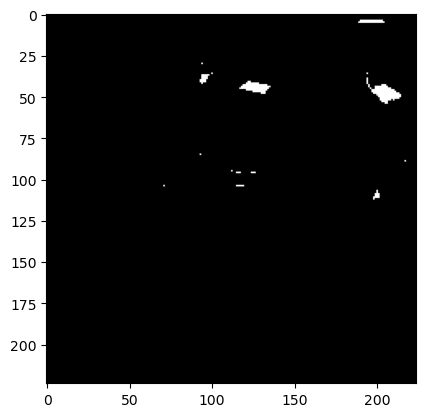

In [13]:
from matplotlib import pyplot as plt

im = image[0,0, :, :].cpu().numpy()

plt.imshow(im.transpose((1, 2, 0)))

plt.show()

In [ ]:
with torch.no_grad():
    image_features = visual_encoder.encode(image.flatten(start_dim=0, end_dim=1))

    image_features = image_features.reshape(*image.shape[:2], -1)

    obs = torch.cat([image_features, act_obs], dim=-1)

    noised_action = torch.randn((1, pred_horizon, action_dim)).to(device)

    timestep_tensor = torch.randint(0, 101, (1,), device=device)

    noise = noise_prediction_net(
        sample=noised_action,
        timestep=timestep_tensor,
        global_cond=obs.flatten(start_dim=1)
    )

    denoised_action = noised_action - noise


In [ ]:
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler

num_diffusion_iters = 100

noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    beta_schedule='squaredcos_cap_v2',
    clip_sample=True,
    prediction_type='epsilon'
)

In [ ]:
from pathlib import Path


def save_final_models(visual_encoder, noise_pred_net, out_dir):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    torch.save(
        {
            "visual_encoder": visual_encoder.state_dict(),
            "noise_pred_net": noise_pred_net.state_dict(),
        },
        out_dir / "model_final.pth",
    )
    print(f"Saved to {out_dir / 'models.pth'}")

def load_final_models(visual_encoder, noise_pred_net, ckpt_path, device="cuda"):
    ckpt_path = Path(ckpt_path)
    state = torch.load(ckpt_path, map_location=device)

    visual_encoder.load_state_dict(state["visual_encoder"], strict=True)
    noise_pred_net.load_state_dict(state["noise_pred_net"], strict=True)

    visual_encoder.to(device).eval()
    noise_pred_net.to(device).eval()
    print(f"Loaded weights from {ckpt_path}")

def save_checkpoint(
    epoch,
    loss,
    visual_encoder,
    noise_pred_net,
    ema,
    optimizer,
    scheduler,
    out_dir="checkpoints",
):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    ckpt_name = f"checkpoint_epoch{epoch:03d}_loss{loss:.4f}.pth"
    torch.save(
        {
            "epoch": epoch,
            "loss": loss,
            "visual_encoder": visual_encoder.state_dict(),
            "noise_pred_net": noise_pred_net.state_dict(),
            "ema": ema.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
        },
        out_dir / ckpt_name,
    )
    print(f"Checkpoint saved to {out_dir / ckpt_name}")

def load_checkpoint(
    ckpt_path,
    visual_encoder,
    noise_pred_net,
    ema,
    optimizer=None,
    scheduler=None,
    map_location="cpu",
):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    visual_encoder.load_state_dict(ckpt["visual_encoder"])
    noise_pred_net.load_state_dict(ckpt["noise_pred_net"])
    ema.load_state_dict(ckpt["ema"])
    if optimizer is not None and "optimizer" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer"])
    if scheduler is not None and "scheduler" in ckpt:
        scheduler.load_state_dict(ckpt["scheduler"])
    print(f"Checkpoint loaded from {ckpt_path}")
    return ckpt["epoch"], ckpt.get("loss", None)


In [ ]:
from torch import nn
from diffusers import EMAModel, get_scheduler

def forward_loss(nbatch):
    nobs  = nbatch['img_obs'][:, :obs_horizon].to(device)
    a_obs = nbatch['act_obs'][:, :obs_horizon].to(device)
    a_gt  = nbatch['act_pred'].to(device)
    B = a_obs.size(0)


    image_features = visual_encoder.encode(nobs.flatten(start_dim=0, end_dim=1))

    image_features = image_features.reshape(*nobs.shape[:2], -1)

    obs = torch.cat([image_features, a_obs], dim=-1)

    obs_cond = obs.flatten(start_dim=1)  # (B, H*obs_dim)

    noise = torch.randn_like(a_gt)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                               (B,), device=device).long()
    noisy_a = noise_scheduler.add_noise(a_gt, noise, timesteps)
    noise_pred = noise_prediction_net(noisy_a, timesteps, global_cond=obs_cond)
    return nn.functional.mse_loss(noise_pred, noise)#%%


In [ ]:
num_epochs = 500

# EMA params
all_params = list(noise_prediction_net.parameters())
ema = EMAModel(parameters=all_params, power=0.75)

# optimizer
optimizer = torch.optim.AdamW(
    params=all_params,
    lr=1e-4,
    weight_decay=1e-6
)

# LR scheduler
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_loader) * num_epochs
)


# train loop
train_hist, val_hist = [], []
for epoch_idx in range(num_epochs):
    epoch_loss_sum = 0.0

    for nbatch in train_loader:
        # prepare data
        nobs = nbatch['img_obs'][:, :obs_horizon].to(device)  # (B, H, state_len)
        action_obs = nbatch['act_obs'][:, :obs_horizon].to(device)  # (B, H, 7)
        action_pred = nbatch['act_pred'].to(device)  # (B, P, 7)
        B = action_obs.size(0)

        image_features = visual_encoder.encode(nobs.flatten(start_dim=0, end_dim=1))

        image_features = image_features.reshape(*nobs.shape[:2], -1)

        obs = torch.cat([image_features, action_obs], dim=-1)

        obs_cond = obs.flatten(start_dim=1)  # (B, H*obs_dim)

        noise = torch.randn_like(action_pred)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (B,), device=device).long()

        noisy_actions = noise_scheduler.add_noise(action_pred, noise, timesteps)
        noise_pred = noise_prediction_net(noisy_actions, timesteps, global_cond=obs_cond)

        loss = nn.functional.mse_loss(noise_pred, noise)

        # backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()
        ema.step(all_params)

        epoch_loss_sum += loss.item()

        avg_train = epoch_loss_sum / len(train_loader)
        train_hist.append(avg_train)

    # validation
    noise_prediction_net.eval()
    val_sum = 0.0
    with torch.no_grad():
        for batch in val_loader:
            val_sum += forward_loss(batch).item()
    avg_val = val_sum / len(val_loader)
    val_hist.append(avg_val)

    print(f"Epoch {epoch_idx+1:03d}/{num_epochs} | "
          f"train {avg_train:.6f} | val {avg_val:.6f}")

    if (epoch_idx + 1) % 10 == 0:
        save_checkpoint(
            epoch=epoch_idx + 1,
            loss=avg_val,
            visual_encoder=visual_encoder,
            noise_pred_net=noise_prediction_net,
            ema=ema,
            optimizer=optimizer,
            scheduler=lr_scheduler,
            out_dir="checkpoints",
        )

# copy EMA weights for inference
ema.copy_to(all_params)

In [ ]:
# ckpt_path = "./checkpoints/checkpoint_epoch190_loss0.0316.pth"
#
# ckpt = torch.load(ckpt_path, map_location="cuda")
# visual_encoder.load_state_dict(ckpt["visual_encoder"])
# noise_prediction_net.load_state_dict(ckpt["noise_pred_net"])

In [ ]:
save_final_models(visual_encoder, noise_prediction_net,
                  "../models/robot_v8_tool_hang_agent_224_epoch215")

In [ ]:
load_final_models(visual_encoder, noise_prediction_net, "../models/robot_v7.1_tool_hang_agent_224_epoch200/model_final.pth")

In [ ]:
val_sum = 0

with torch.no_grad():
        for batch in val_loader:
            val_sum += forward_loss(batch).item()

val_sum / len(val_loader)

# Inference

In [ ]:
import robomimic
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.file_utils as FileUtils
from robomimic.utils.vis_utils import depth_to_rgb
from robomimic.envs.env_base import EnvBase, EnvType

from tqdm import tqdm

import os

env_meta = FileUtils.get_env_metadata_from_dataset(dataset_path=data_path)
env_meta["env_kwargs"]["reward_shaping"] = True
env_meta["env_kwargs"]["reward_scale"]   = 1.0

dummy_spec = dict(
    obs=dict(
        low_dim=["robot0_eef_pos"],
        rgb=["agentview_image"]
        # rgb=["robot0_eye_in_hand_image"]
    ),
)

ObsUtils.initialize_obs_utils_with_obs_specs(obs_modality_specs=dummy_spec)

env = EnvUtils.create_env_from_metadata(env_meta=env_meta, render=True, render_offscreen=True, use_image_obs=True)

a = env.reset()

from collections import deque
obs_deque  = deque(maxlen=obs_horizon)
act_deque  = deque(maxlen=obs_horizon)
rewards    = []
imgs       = []
step_idx   = 0

max_steps = 500
action_horizon  = 4

# ─── 6. Main rollout ──────────────────────────────────────────────────────────
obs = env.reset()
# wrap obs in same format as env.step
obs = obs if isinstance(obs, dict) else obs[0]
for i in range(obs_deque.maxlen):
    obs_deque.append(obs)
    act_deque.append(np.zeros(action_dim, dtype=np.float32))

pbar = tqdm(total=max_steps)
done = False

while not done and step_idx < max_steps:
    # 6.1 build the image & action history tensor
    img_np = np.array([obs_deque[i][camera_type + "_image"] for i in range(obs_deque.maxlen)])

    img_t   = torch.from_numpy(img_np).float().to(device)

    actions_hist = torch.stack(
        [torch.from_numpy(a) for a in list(act_deque)],
        dim=0
    ).to(device)                           # (1, H_a, 7)

    # 6.2 compute visual features + conditioning
    with torch.no_grad():
        img_feat = visual_encoder(img_t)                # (1, C)
        obs_cond = torch.cat([img_feat.flatten(start_dim=0).unsqueeze(0) , actions_hist.flatten(start_dim=0).unsqueeze(0)], dim=1)

        # 6.3 sample a future action sequence via diffusion
        B = 1
        pred_actions = torch.randn((B, pred_horizon, action_dim), device=device)
        noise_scheduler.set_timesteps(num_diffusion_iters)
        for t in noise_scheduler.timesteps:
            noise_pred    = noise_prediction_net(pred_actions, t, global_cond=obs_cond)
            out           = noise_scheduler.step(noise_pred, t, pred_actions)
            pred_actions  = out.prev_sample

    pred_actions = pred_actions.cpu().numpy()[0]        # (pred_horizon, 7)

    # 6.4 execute the next block of actions
    start = obs_horizon
    end   = start + action_horizon
    action_block = pred_actions[start:end]          # (5, 7)

    for act in action_block:
        obs, rew, done, info = env.step(act)
        obs = obs if isinstance(obs, dict) else obs[0]

        frame = env.render(mode="rgb_array", height=512, width=512)

        obs_deque.append(obs)
        act_deque.append(act.astype(np.float32))

        rewards.append(rew)
        imgs.append(frame)

        step_idx += 1
        pbar.update(1)
        pbar.set_postfix(reward=float(rew))

        if done or step_idx >= max_steps:
            break

pbar.close()

# ─── 7. Wrap up ───────────────────────────────────────────────────────────────
print(f"Rollout finished: {step_idx} steps, total reward {sum(rewards):.2f}")

In [ ]:
import imageio

video_path = "test_larger_size_img.mp4"
fps = 24

with imageio.get_writer(video_path, fps=fps, codec="libx264") as writer:
    for frame in imgs:
        writer.append_data(frame)

print(f"Saved video to {video_path}")

In [ ]:
img = img_np[0]

In [ ]:
plt.imshow(img.transpose(1,2,0))